In [1]:
import csv
from scipy import sparse
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
base_path = '/bigstore/binfo/mouse/Brain/Sequencing/Allen_10X_SmartSeqTypes/'
genes = np.array(list(pd.read_csv(os.path.join(base_path,'gene_name.csv'),index_col=0)['x']))
cells = np.array(list(pd.read_csv(os.path.join(base_path,'sample_name.csv'),index_col=0)['x']))
metadata = pd.read_csv(os.path.join(base_path,'metadata.csv'),index_col=0).loc[cells]
counts = np.load(os.path.join(base_path,'matrix.npy'))
cell_size = np.sum(counts,axis=1)/(5*(10**5))
celltypes = np.array(metadata['cell_type_alias_label'].unique())
celltypes = np.array([i for i in celltypes if isinstance(i,str)])
normcounts = np.stack([(counts[i,:]/cell_size[i]).astype('uint16') for i in tqdm(range(counts.shape[0]),total=counts.shape[0])])
np.save(os.path.join(base_path,'normcounts.npy'),normcounts)
metadata['counts_loc'] = range(normcounts.shape[0]) 
del counts

/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|██████████| 1093036/1093036 [03:24<00:00, 5332.64it/s]


In [11]:
metadata.shape

(1093036, 57)

In [10]:
normcounts.shape

(1093036, 31053)

In [12]:
import importlib
cword_config = 'seqfish_config_tbi_v4'
config = importlib.import_module(cword_config)
tbi_genes = config.gids

In [ ]:
"""
Find 100 genes that seperate all high level types well
"""

In [13]:
high_level_celltypes_dict = {i:i.split('_')[1] for i in celltypes if i!=np.nan}
high_level_celltypes_dict[np.nan] = 'nan'
high_level_labels = [high_level_celltypes_dict[i] for i in metadata['cell_type_alias_label']]
metadata['high_level_label'] = high_level_labels
metadata = metadata[metadata['high_level_label']!='nan']
high_level_celltypes = np.unique(metadata['high_level_label'])
high_level_celltypes=high_level_celltypes
high_level_celltypes

array(['Astro', 'CA1', 'CA1-ProS', 'CA2-IG-FC', 'CA3', 'CR', 'CT SUB',
       'DG', 'Endo', 'L2 IT ENTl', 'L2 IT ENTm', 'L2 IT HATA',
       'L2 IT PAR', 'L2 IT ProS', 'L2 IT RSP-ACA', 'L2 IT RSPv',
       'L2/3 IT APr', 'L2/3 IT CTX', 'L2/3 IT ENTl', 'L2/3 IT PPP',
       'L2/3 IT TPE', 'L3 IT ENTl', 'L3 IT ENTm', 'L3 RSP-ACA',
       'L4/5 IT CTX', 'L4/5 IT TPE-ENT', 'L5 IT CTX', 'L5 IT TPE-ENT',
       'L5 NP CTX', 'L5 PPP', 'L5 PT CTX', 'L5 PT RSP-ACA', 'L5/6 IT CTX',
       'L6 CT CTX', 'L6 CT ENTm', 'L6 Car3', 'L6 IT CTX', 'L6 IT ENTl',
       'L6 IT RHP', 'L6 NP CT CTX', 'L6b CTX', 'L6b RHP', 'L6b/CT ENT',
       'Lamp5', 'Lamp5 Lhx6', 'Meis2', 'Micro', 'NP PPP', 'NP SUB',
       'Ndnf HPF', 'OPC', 'Oligo', 'PVM', 'Pax6', 'Peri', 'ProS', 'Pvalb',
       'Pvalb Vipr2', 'SMC', 'SUB', 'SUB-ProS', 'Sncg', 'Sst',
       'Sst Chodl', 'V3d', 'VLMC', 'Vip'], dtype=object)

In [14]:
unqtypes = np.unique(metadata[metadata['region_label']=='HIP']['cell_type_alias_label'])
Gmu = np.zeros((len(genes),len(unqtypes)))
Gstd = np.zeros((len(genes),len(unqtypes)))
for i,ct in tqdm(enumerate(unqtypes),total=len(unqtypes)):
    ct_indexes = list(metadata[(metadata['region_label']=='HIP')&(metadata['cell_type_alias_label']==ct)]['counts_loc'])
    if len(ct_indexes)>1:
        Gmu[:,i] = np.mean(normcounts[ct_indexes,:],axis=0)
        Gstd[:,i] = np.std(normcounts[ct_indexes,:],axis=0)
    else:
        Gmu[:,i] = normcounts[ct_indexes,:]
        Gstd[:,i] = normcounts[ct_indexes,:]
Gmu_max = np.max(Gmu,axis=1)
Gsep = np.array([np.nanmean(np.abs(Gmu[i,:,None]-Gmu[i,None,:])) for i in tqdm(range(Gmu.shape[0]))])
Gstd_max = Gstd[range(0,Gstd.shape[0]),np.argmax(Gmu,axis=1)]

 90%|████████▉ | 149/166 [01:12<00:08,  2.06it/s]


KeyboardInterrupt: 

12864


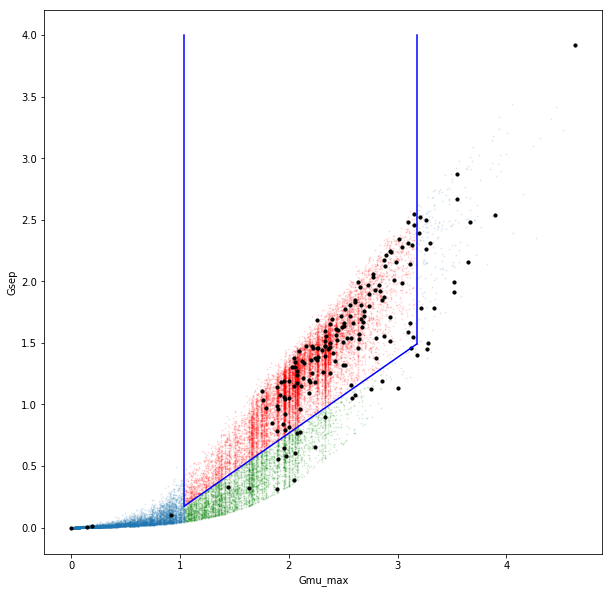

In [14]:
import matplotlib.pyplot as plt
m_min = np.log10(10+1)
m_max = np.log10(1500+1)
m_sep_min = np.log10(0.5+1)
m_sep_max = np.log10(30+1)
# X = Gmu_max
# Y = Gsep
# Y = mx+b
# Slope = (y2-y1)(x2-x1)
# Intercept = Y-mx
sep_slope = (m_sep_max-m_sep_min)/(m_max-m_min)
sep_intercept = m_sep_min-(m_min*sep_slope)
mu_mask = (Gmu_max>10)&(Gmu_max<1500)
sep_mask = (np.log10(Gsep+1)>((np.log10(Gmu_max+1)*sep_slope)+sep_intercept))
print(len(genes[mu_mask&sep_mask]))
x = np.linspace(m_min,m_max,num=10)
y = (x*sep_slope)+sep_intercept
plt.figure(figsize=[10,10])
plt.plot(x,y,c='b')
plt.scatter(np.log10(Gmu_max[(mu_mask==False)]+1),np.log10(Gsep[(mu_mask==False)]+1),s=1,alpha=0.1)
plt.scatter(np.log10(Gmu_max[(mu_mask)&(sep_mask==False)]+1),np.log10(Gsep[(mu_mask)&(sep_mask==False)]+1),c='g',s=1,alpha=0.1)
plt.scatter(np.log10(Gmu_max[(mu_mask)&(sep_mask)]+1),np.log10(Gsep[(mu_mask)&(sep_mask)]+1),s=1,c='r',alpha=0.1)
plt.scatter(np.log10(Gmu_max[np.isin(genes,tbi_genes)]+1),np.log10(Gsep[np.isin(genes,tbi_genes)]+1),s=10,c='K',alpha=1)
# plt.plot([m_min,m_max],[m_sep_min,m_sep_max],c='g')
plt.plot([m_min,m_min],[m_sep_min,4],c='b')
plt.plot([m_max,m_max],[m_sep_max,4],c='b')
plt.xlabel('Gmu_max')
plt.ylabel('Gsep')
plt.show()

7572


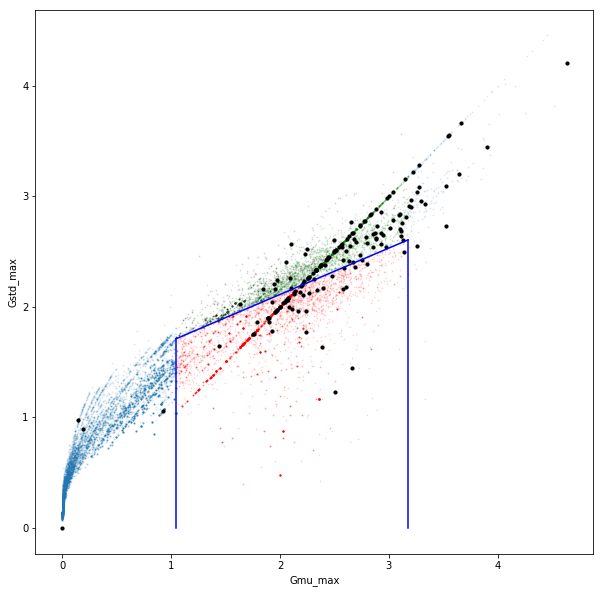

In [15]:
import matplotlib.pyplot as plt
m_min = np.log10(10+1)
m_max = np.log10(1500+1)
m_std_min = np.log10(50+1)
m_std_max = np.log10(400+1)
std_slope = (m_std_max-m_std_min)/(m_max-m_min)
std_intercept = m_std_min-(m_min*std_slope)
std_mask = (np.log10(Gstd_max+1)<(np.log10(Gmu_max+1)*std_slope)+std_intercept)
print(len(genes[mu_mask&std_mask&sep_mask]))
x = np.linspace(m_min,m_max,num=10)
y = (x*std_slope)+std_intercept
plt.figure(figsize=[10,10])
plt.plot(x,y,c='b')
plt.plot([m_min,m_min],[m_std_min,0],c='b')
plt.plot([m_max,m_max],[m_std_max,0],c='b')
plt.scatter(np.log10(Gmu_max[mu_mask==False]+1),np.log10(Gstd_max[mu_mask==False]+1),s=1,alpha=0.1)
plt.scatter(np.log10(Gmu_max[(mu_mask)&(std_mask==False)&(sep_mask==False)]+1),np.log10(Gstd_max[(mu_mask)&(std_mask==False)&(sep_mask==False)]+1),c='k',s=1,alpha=0.1)
plt.scatter(np.log10(Gmu_max[(mu_mask)&(std_mask==False)&(sep_mask)]+1),np.log10(Gstd_max[(mu_mask)&(std_mask==False)&(sep_mask)]+1),s=1,alpha=0.1,c='g')
plt.scatter(np.log10(Gmu_max[(mu_mask)&(std_mask)&(sep_mask)]+1),np.log10(Gstd_max[(mu_mask)&(std_mask)&(sep_mask)]+1),s=1,c='r',alpha=0.1)
plt.scatter(np.log10(Gmu_max[np.isin(genes,tbi_genes)]+1),np.log10(Gstd_max[np.isin(genes,tbi_genes)]+1),s=10,c='K',alpha=1)
plt.xlabel('Gmu_max')
plt.ylabel('Gstd_max')
plt.show()

In [16]:
filtered_counts = normcounts[:,((Gmu_max>10)&(Gmu_max<1500))]#&std_mask&sep_mask)]
filtered_genes = genes[((Gmu_max>10)&(Gmu_max<1500))]
filtered_counts.shape

(1093036, 17283)

In [18]:
ct_indexes = np.array(list(metadata[(metadata['region_label']=='HIP')]['counts_loc']))
hip_filtered_counts = filtered_counts[ct_indexes,:]
hip_labels = np.array(list(metadata[(metadata['region_label']=='HIP')]['cell_type_alias_label']))

In [ ]:
unique_labels = np.unique(true)
label_converter = {label:i for i,label in enumerate(unique_labels)}
true_converted = np.array([label_converter[i] for i in true])
predicted_converted = np.array([label_converter[i] for i in predicted])

In [30]:
import seaborn as sns
def show_confusion_matrix(unique_labels,true,predicted):
    label_converter = {label:i for i,label in enumerate(unique_labels)}
    true_converted = np.array([label_converter[i] for i in true])
    predicted_converted = np.array([label_converter[i] for i in predicted])
    confmat = np.zeros((len(unique_labels),len(unique_labels)))
    for i,it in enumerate(unique_labels):
        it_converted = label_converter[it]
        for j,jt in enumerate(unique_labels):
            jt_converted = label_converter[jt]
            confmat[i,j] = np.sum((true_converted==it_converted)&(predicted_converted==jt_converted))/np.sum((true_converted==it_converted))
    confmat = pd.DataFrame(confmat,index=unique_labels,columns=unique_labels)
    plt.figure(figsize=[10,10])
    sns.heatmap(confmat,cmap='Reds')
    plt.show()

In [19]:
# Generate test train set 
ncells = hip_filtered_counts.shape[0]
test_indexes = np.random.choice(np.array(range(ncells)),int(0.25*ncells))
train_indexes = np.array(range(ncells))[(np.isin(np.array(range(ncells)),test_indexes)==False)]
test_counts = hip_filtered_counts[test_indexes,:]
train_counts = hip_filtered_counts[train_indexes,:]
test_labels = hip_labels[test_indexes]
train_labels = hip_labels[train_indexes]
print('test:',test_counts.shape,'train:',train_counts.shape)

test: (19356, 17283) train: (60278, 17283)


100%|██████████| 298/298 [00:04<00:00, 67.19it/s] 
/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


(0.9684455746679589, 0.8360198388096715)


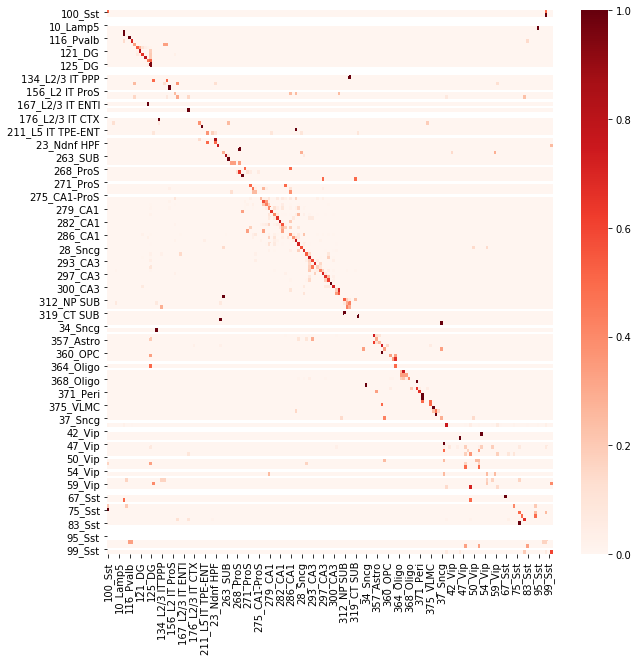

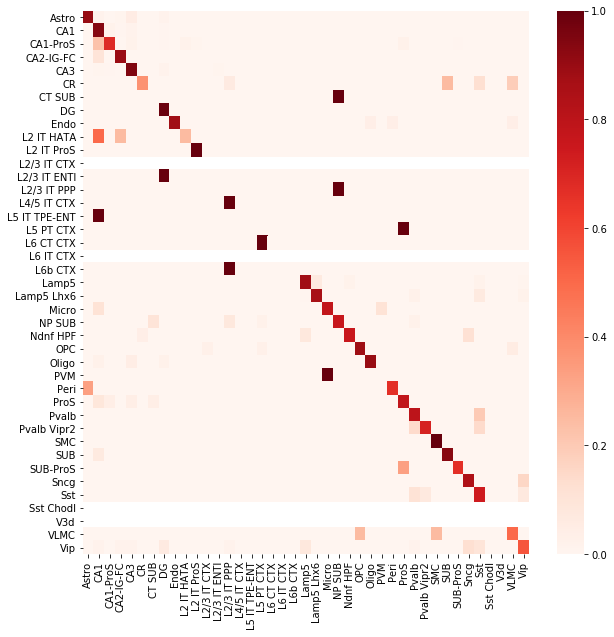

In [206]:
# check TBI Genes
mask = np.isin(genes,tbi_genes)
filtered_genes = genes[((Gmu_max>10)&(Gmu_max<1500))]
tbi_filtered_genes = filtered_genes[np.isin(filtered_genes,tbi_genes)]
tbi_test_counts = test_counts[:,np.isin(filtered_genes,tbi_genes)]
tbi_train_counts = train_counts[:,np.isin(filtered_genes,tbi_genes)]

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(tbi_train_counts,train_labels)
predicted = lda.predict(tbi_test_counts)
true = test_labels.copy()
print(calculate_AUC(linkage,true,predicted))
show_confusion_matrix(np.unique(hip_labels),true,predicted)
show_confusion_matrix(np.unique([i.split('_')[1] for i in np.unique(hip_labels)]),np.array([i.split('_')[1] for i in true]),np.array([i.split('_')[1] for i in predicted]))

/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
100%|██████████| 298/298 [00:04<00:00, 67.66it/s] 
/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


(0.9833570175776488, 0.9052490183922298)


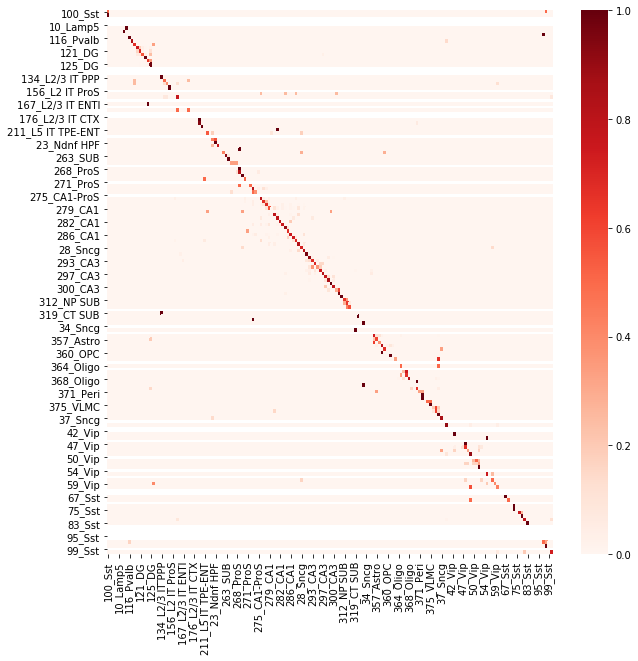

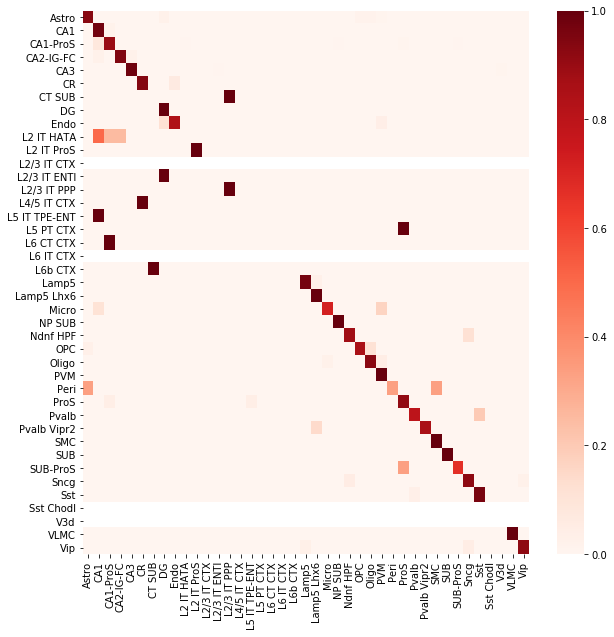

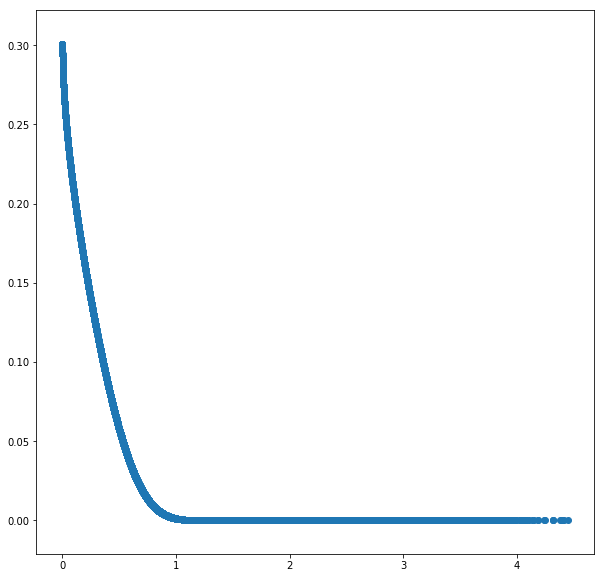

In [247]:
from sklearn.feature_selection import f_regression

out = f_regression(train_counts,np.array([leaf_idx_converter[i] for i in train_labels]))
temp = out[0].copy()
temp = np.nan_to_num(temp,nan=0)
temp[temp>10**10]=0
gi = temp.argsort()[-150:]
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(train_counts[:,gi],train_labels)
predicted = lda.predict(test_counts[:,gi])

print(calculate_AUC(linkage,true,predicted))
show_confusion_matrix(np.unique(hip_labels),true,predicted)
show_confusion_matrix(np.unique([i.split('_')[1] for i in np.unique(hip_labels)]),np.array([i.split('_')[1] for i in true]),np.array([i.split('_')[1] for i in predicted]))
plt.figure(figsize=[10,10])
plt.scatter(np.log10(out[0]+1),np.log10(out[1]+1))
plt.show()

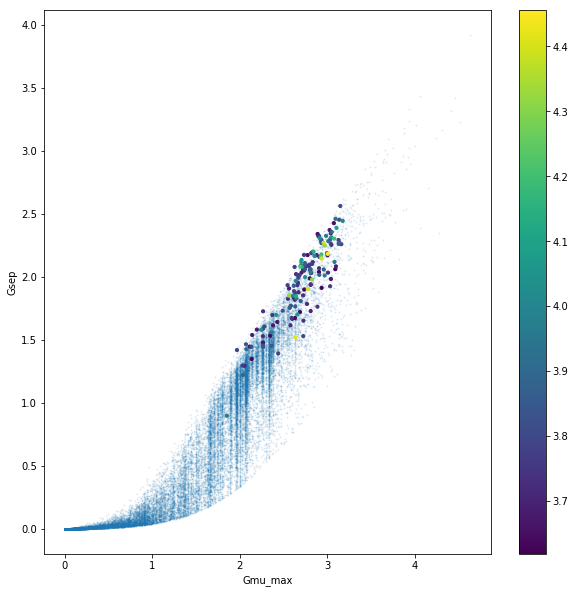

In [248]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,10])
plt.scatter(np.log10(Gmu_max+1),np.log10(Gsep+1),s=1,alpha=0.1)
plt.scatter(np.log10(Gmu_max[np.isin(genes,filtered_genes[gi])]+1),np.log10(Gsep[np.isin(genes,filtered_genes[gi])]+1),s=10,c=np.log10(out[0]+1)[gi],alpha=1)
plt.colorbar()
plt.xlabel('Gmu_max')
plt.ylabel('Gsep')
plt.show()

In [252]:
out = f_regression(train_counts,np.array([leaf_idx_converter[i] for i in train_labels]))
temp = out[0].copy()
temp = np.nan_to_num(temp,nan=0)
temp[temp>10**10]=0
gi = temp.argsort()[-150:]
pd.Series(filtered_genes[gi]).to_csv(os.path.join(base_path,'merfish_final_genes.csv'),index=False)

/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [78]:
"""ROC Dendrogram"""
# Load Dendrogram
def find_next_nodes(node):
    if 'leaf_attributes' in node.keys():
        A = None
        B = None
        C = node['leaf_attributes'][0]['original_label']
        H = node['leaf_attributes'][0]['height']
        Children = []
    elif 'node_attributes' in node.keys():
        try:
            A = node['children'][0]['node_attributes'][0]['original_label']
        except:
            A = node['children'][0]['leaf_attributes'][0]['original_label']
        try:
            B = node['children'][1]['node_attributes'][0]['original_label']
        except:
            B = node['children'][1]['leaf_attributes'][0]['original_label']
        C = node['node_attributes'][0]['original_label']
        H = node['node_attributes'][0]['height']
        Children = node['children']
    return A,B,C,H,Children
def dend2linkage(dend):
    A_list = []
    B_list = []
    C_list = []
    H_list = []
    Children_list = []
    A,B,C,H,Children = find_next_nodes(dend)
    A_list.append(A)
    B_list.append(B)
    C_list.append(C)
    H_list.append(H)
    Children_list.extend(Children)
    while len(Children_list)>0:
        new_Children_list = []
        for child in Children_list:
            A,B,C,H,Children = find_next_nodes(child)
            A_list.append(A)
            B_list.append(B)
            C_list.append(C)
            H_list.append(H)
            new_Children_list.extend(Children)
        Children_list = new_Children_list
    linkage = pd.DataFrame()
    linkage['A'] = A_list
    linkage['B'] = B_list
    linkage['C'] = C_list
    linkage['H'] = H_list
    linkage = linkage.sort_values('H')
    return linkage

import json
with open(os.path.join(base_path,'dend.json')) as f:
    dend = json.load(f)
linkage = dend2linkage(dend)


In [114]:
""" node by leaf matrix"""
def linkage_to_nodeleaf(linkage):
    leaves = np.array(linkage[linkage['H']==0]['C'])
    nodes = np.array(linkage[linkage['H']!=0]['C'])
    leaf_idx_converter = {leaf:i for i,leaf in enumerate(leaves)}
    node_idx_converter = {node:i for i,node in enumerate(nodes)}
    presence_matrix = np.zeros((len(leaves),len(nodes)))
    for leaf in tqdm(leaves):
        i = leaf_idx_converter[leaf]
        next_node = np.array(linkage[(linkage['A']==leaf)|(linkage['B']==leaf)]['C'])
        while next_node.shape[0]>0:
            presence_matrix[i,node_idx_converter[next_node[0]]] = 1
            next_node = np.array(linkage[(linkage['A']==next_node[0])|(linkage['B']==next_node[0])]['C'])
    node2leaf_df = pd.DataFrame(presence_matrix,index=leaves,columns=nodes)
    return node2leaf_df
node2leaf_df = linkage_to_nodeleaf(linkage)

100%|██████████| 379/379 [00:14<00:00, 25.65it/s]


In [188]:
def calculate_ROC(linkage,true,predicted):
    accuracy = []
    present_leaves = np.unique(true)
    leaves = np.array(linkage[linkage['H']==0]['C'])
    absent_leaves = leaves[np.isin(leaves,present_leaves)==False]
    temp_linkage = linkage[np.isin(np.array(linkage['C']),absent_leaves)==False]
    tp_h = np.zeros(true.shape[0])
    for h in tqdm(temp_linkage['H'].unique()):
        for ct in temp_linkage[temp_linkage['H']==h]['C']:
            if ct in leaves:
                tp_h[np.isin(true,np.array(ct))&np.isin(predicted,np.array(ct))] = 1
            else:
                node_leaves = leaves[np.array(node2leaf_df[ct])==1]
                tp_h[np.isin(true,node_leaves)&np.isin(predicted,node_leaves)] = 1
        accuracy.append(np.sum(tp_h)/tp_h.shape[0])
    return np.array(accuracy), np.array(linkage['H'].unique())
def calculate_AUC(linkage,true,predicted):
    test_a,test_h = calculate_ROC(linkage,true,predicted)
    shuffled = true.copy()
    np.random.shuffle(shuffled)
    perm_a,perm_h = calculate_ROC(linkage,true,shuffled)
    auc = np.trapz(test_a,perm_a)/np.trapz(np.ones_like(perm_a),perm_a)
    accuracy = len([i for i in range(predicted.shape[0]) if predicted[i]==true[i]])/predicted.shape[0]
    return auc,accuracy
import seaborn as sns
def show_confusion_matrix(unique_labels,true,predicted):
    label_converter = {label:i for i,label in enumerate(unique_labels)}
    true_converted = np.array([label_converter[i] for i in true])
    predicted_converted = np.array([label_converter[i] for i in predicted])
    confmat = np.zeros((len(unique_labels),len(unique_labels)))
    for i,it in enumerate(unique_labels):
        it_converted = label_converter[it]
        for j,jt in enumerate(unique_labels):
            jt_converted = label_converter[jt]
            confmat[i,j] = np.sum((true_converted==it_converted)&(predicted_converted==jt_converted))/np.sum((true_converted==it_converted))
    confmat = pd.DataFrame(confmat,index=unique_labels,columns=unique_labels)
    plt.figure(figsize=[10,10])
    sns.heatmap(confmat,cmap='Reds')
    plt.show()

In [1]:
import pandas as pd

fpkm = pd.read_csv(os.path.join(resource_path,'Cornea_FPKM.csv'),index_col=0)
fpkm.head()

NameError: name 'pd' is not defined